## 1. Importing Data

In [1]:
#importing libraries
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [4]:
#adding the data for chicago year 2022
data = pd.read_csv('2022_all_year.csv')

## 2. Preprocessing Data

Looking at the column in the data

In [5]:
data.columns

Index(['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type',
       'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat',
       'District', 'Ward', 'Community Area', 'FBI Code', 'X Coordinate',
       'Y Coordinate', 'Year', 'Updated On', 'Latitude', 'Longitude',
       'Location', 'Historical Wards 2003-2015', 'Zip Codes',
       'Community Areas', 'Census Tracts', 'Wards', 'Boundaries - ZIP Codes',
       'Police Districts', 'Police Beats'],
      dtype='object')

Dropping any unecessary column

In [6]:
data = data.drop(data.columns[[0,1,3,4,7,9,10,11,12,13,14,17,18,21,22,23,24,25,26,27,28,29]],axis=1)
#axis = 1 means that the operation are perform on the columns of the DataFrame

In [7]:
data.columns

Index(['Date', 'Primary Type', 'Description', 'Arrest', 'X Coordinate',
       'Y Coordinate', 'Latitude', 'Longitude'],
      dtype='object')

In [8]:
data.head(15)

,Date,Primary Type,Description,Arrest,X Coordinate,Y Coordinate,Latitude,Longitude
0,12/31/2022 11:50:00 PM,MOTOR VEHICLE THEFT,AUTOMOBILE,False,1165385.0,1946614.0,42.009108,-87.666844
1,12/31/2022 11:50:00 PM,BATTERY,DOMESTIC BATTERY SIMPLE,False,1139357.0,1900199.0,41.882257,-87.763744
2,12/31/2022 11:47:00 PM,ASSAULT,SIMPLE,True,1167940.0,1844124.0,41.727812,-87.660399
3,12/31/2022 11:47:00 PM,WEAPONS VIOLATION,UNLAWFUL POSSESSION - HANDGUN,True,1167940.0,1844124.0,41.727812,-87.660399
4,12/31/2022 11:45:00 PM,MOTOR VEHICLE THEFT,AUTOMOBILE,False,1169346.0,1830494.0,41.690379,-87.655642
5,12/31/2022 11:45:00 PM,WEAPONS VIOLATION,UNLAWFUL POSSESSION - HANDGUN,True,1173883.0,1905665.0,41.896557,-87.636802
6,12/31/2022 11:45:00 PM,OTHER OFFENSE,HARASSMENT BY TELEPHONE,False,1142695.0,1899189.0,41.879424,-87.751512
7,12/31/2022 11:45:00 PM,BATTERY,SIMPLE,False,1177394.0,1901277.0,41.884437,-87.624040
8,12/31/2022 11:44:00 PM,CRIMINAL TRESPASS,TO LAND,False,1163051.0,1889068.0,41.851248,-87.677052
9,12/31/2022 11:44:00 PM,CRIMINAL DAMAGE,TO PROPERTY,False,NaN,NaN,NaN,NaN


removing the rows with any NaN

In [9]:
data = data.dropna()
data

,Date,Primary Type,Description,Arrest,X Coordinate,Y Coordinate,Latitude,Longitude
0,12/31/2022 11:50:00 PM,MOTOR VEHICLE THEFT,AUTOMOBILE,False,1165385.0,1946614.0,42.009108,-87.666844
1,12/31/2022 11:50:00 PM,BATTERY,DOMESTIC BATTERY SIMPLE,False,1139357.0,1900199.0,41.882257,-87.763744
2,12/31/2022 11:47:00 PM,ASSAULT,SIMPLE,True,1167940.0,1844124.0,41.727812,-87.660399
3,12/31/2022 11:47:00 PM,WEAPONS VIOLATION,UNLAWFUL POSSESSION - HANDGUN,True,1167940.0,1844124.0,41.727812,-87.660399
4,12/31/2022 11:45:00 PM,MOTOR VEHICLE THEFT,AUTOMOBILE,False,1169346.0,1830494.0,41.690379,-87.655642
...,...,...,...,...,...,...,...,...
237351,01/01/2022 12:00:00 AM,DECEPTIVE PRACTICE,CREDIT CARD FRAUD,False,1169722.0,1917469.0,41.929039,-87.651740
237352,01/01/2022 12:00:00 AM,CRIMINAL DAMAGE,TO PROPERTY,False,1191357.0,1852335.0,41.749809,-87.574354
237353,01/01/2022 12:00:00 AM,OTHER OFFENSE,HARASSMENT BY TELEPHONE,False,1166434.0,1861907.0,41.776643,-87.665410
237355,01/01/2022 12:00:00 AM,THEFT,OVER $500,False,1165777.0,1899437.0,41.879643,-87.666751


Looking at the data yype of each column

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 233173 entries, 0 to 237357
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Date          233173 non-null  object 
 1   Primary Type  233173 non-null  object 
 2   Description   233173 non-null  object 
 3   Arrest        233173 non-null  bool   
 4   X Coordinate  233173 non-null  float64
 5   Y Coordinate  233173 non-null  float64
 6   Latitude      233173 non-null  float64
 7   Longitude     233173 non-null  float64
dtypes: bool(1), float64(4), object(3)
memory usage: 14.5+ MB


Converting the 'Date' column to a date data type 

In [14]:
data['Date']=pd.to_datetime(data['Date'])
print(data.head())

                 Date         Primary Type                    Description  \
0 2022-12-31 23:50:00  MOTOR VEHICLE THEFT                     AUTOMOBILE   
1 2022-12-31 23:50:00              BATTERY        DOMESTIC BATTERY SIMPLE   
2 2022-12-31 23:47:00              ASSAULT                         SIMPLE   
3 2022-12-31 23:47:00    WEAPONS VIOLATION  UNLAWFUL POSSESSION - HANDGUN   
4 2022-12-31 23:45:00  MOTOR VEHICLE THEFT                     AUTOMOBILE   

   Arrest  X Coordinate  Y Coordinate   Latitude  Longitude  
0   False     1165385.0     1946614.0  42.009108 -87.666844  
1   False     1139357.0     1900199.0  41.882257 -87.763744  
2    True     1167940.0     1844124.0  41.727812 -87.660399  
3    True     1167940.0     1844124.0  41.727812 -87.660399  
4   False     1169346.0     1830494.0  41.690379 -87.655642  


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 233173 entries, 0 to 237357
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Date          233173 non-null  datetime64[ns]
 1   Primary Type  233173 non-null  object        
 2   Description   233173 non-null  object        
 3   Arrest        233173 non-null  bool          
 4   X Coordinate  233173 non-null  float64       
 5   Y Coordinate  233173 non-null  float64       
 6   Latitude      233173 non-null  float64       
 7   Longitude     233173 non-null  float64       
dtypes: bool(1), datetime64[ns](1), float64(4), object(2)
memory usage: 14.5+ MB


## 3. Exploratory Data Analysis (EDA)

In [22]:
crime = data['Primary Type'].unique()
print(crime ,'\n')
print('Number of type of crime: ', len(crime))

['MOTOR VEHICLE THEFT' 'BATTERY' 'ASSAULT' 'WEAPONS VIOLATION'
 'OTHER OFFENSE' 'CRIMINAL TRESPASS' 'CRIMINAL DAMAGE' 'BURGLARY'
 'HOMICIDE' 'SEX OFFENSE' 'THEFT' 'ROBBERY' 'NARCOTICS'
 'DECEPTIVE PRACTICE' 'PUBLIC PEACE VIOLATION'
 'OFFENSE INVOLVING CHILDREN' 'STALKING' 'ARSON' 'CRIMINAL SEXUAL ASSAULT'
 'INTIMIDATION' 'KIDNAPPING' 'INTERFERENCE WITH PUBLIC OFFICER'
 'CONCEALED CARRY LICENSE VIOLATION' 'OBSCENITY'
 'OTHER NARCOTIC VIOLATION' 'PROSTITUTION' 'NON-CRIMINAL'
 'LIQUOR LAW VIOLATION' 'HUMAN TRAFFICKING' 'PUBLIC INDECENCY' 'GAMBLING'] 

Number of type of crime:  31


In [16]:
crime = pd.DataFrame(data['Primary Type'].value_counts())
crime.iloc[:,]


,Primary Type
THEFT,53138
BATTERY,40693
CRIMINAL DAMAGE,26912
MOTOR VEHICLE THEFT,21268
ASSAULT,20691
DECEPTIVE PRACTICE,14761
OTHER OFFENSE,14232
ROBBERY,8953
WEAPONS VIOLATION,8697
BURGLARY,7520


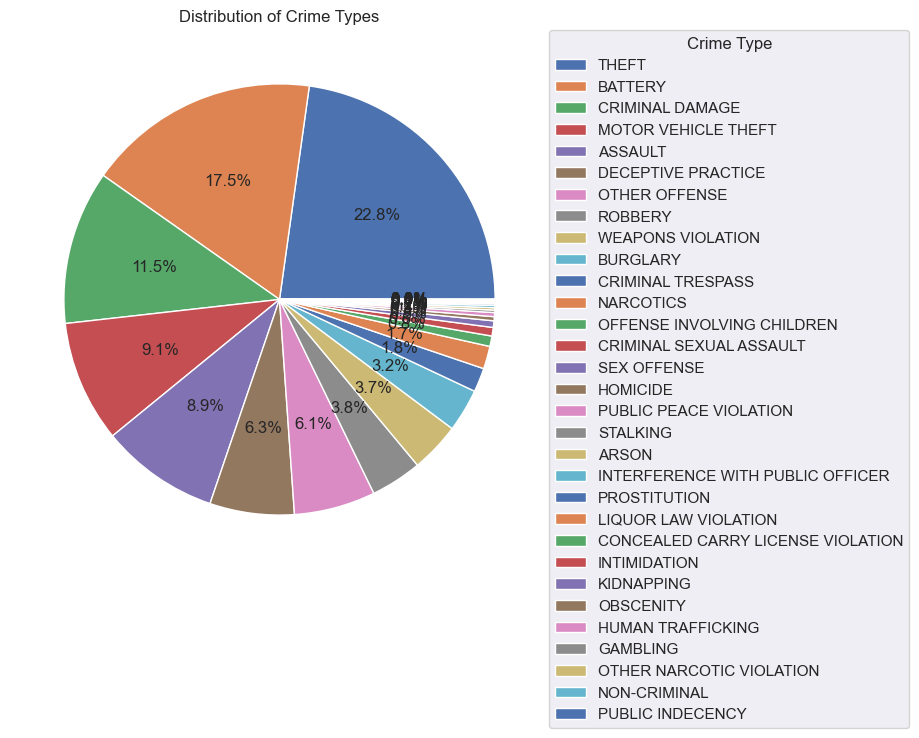

In [47]:

# Count the occurrences of each crime type
crime_counts = data['Primary Type'].value_counts()

# Sort the crime types by the number of crimes in descending order
crime_counts = crime_counts.sort_values(ascending=False)

# Create a pie chart using pandas
fig, ax = plt.subplots(figsize=(20, 7))
ax.pie(crime_counts.values, labels=None, autopct='%1.1f%%')
ax.set_title('Distribution of Crime Types')

# Show the plot
plt.legend(labels=crime_counts.index, bbox_to_anchor=(1,1), loc='upper left', borderaxespad=0, title='Crime Type')
plt.show()

Theft is choosen as it is the highest type of crime rate 

In [62]:
theft = data[data['Primary Type'].str.startswith('THEFT')]
theft

,Date,Primary Type,Description,Arrest,X Coordinate,Y Coordinate,Latitude,Longitude
53,2022-12-31 22:30:00,THEFT,FROM BUILDING,False,1179396.0,1903711.0,41.891070,-87.616614
82,2022-12-31 21:50:00,THEFT,OVER $500,False,1137758.0,1867507.0,41.792574,-87.770402
99,2022-12-31 21:12:00,THEFT,RETAIL THEFT,False,1161020.0,1870793.0,41.801141,-87.685012
105,2022-12-31 21:00:00,THEFT,OVER $500,False,1155665.0,1890311.0,41.854810,-87.704127
111,2022-12-31 21:00:00,THEFT,$500 AND UNDER,False,1177991.0,1856429.0,41.761357,-87.623209
...,...,...,...,...,...,...,...,...
237329,2022-01-01 00:00:00,THEFT,$500 AND UNDER,False,1148721.0,1913242.0,41.917872,-87.729022
237333,2022-01-01 00:00:00,THEFT,OVER $500,False,1159793.0,1874504.0,41.811350,-87.689410
237341,2022-01-01 00:00:00,THEFT,$500 AND UNDER,False,1171333.0,1891003.0,41.856380,-87.646598
237350,2022-01-01 00:00:00,THEFT,POCKET-PICKING,False,1171576.0,1915192.0,41.922751,-87.644994


Plotting theft by the months

In [64]:
sns.set(rc={'figure.figsize': (20,7)})
graph = sns.countplot(x ='Date', data = data, palette= 'hls').set(title='Distribution of Crime Types (May 2021-May 2022)')
plt.legend(bbox_to_anchor=(1.01, 0.7), loc='upper left', borderaxespad=0, title='Crime Type')

KeyboardInterrupt: 